In [1]:
#!pip install -U jupyter
#!pip install torch
#!pip install torchsummary
#!pip install torchvision
#!pip install tensorflow-gpu
#!pip install pycocotools
#!conda remove tensorflow-gpu
#!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html
#!pip install opencv-python 

In [2]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
device = torch.device("cuda") 


1.5.0+cu101 True


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import pickle
import random
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import deepdish as dd
import pycocotools as pycoco
import warnings
import os
warnings.filterwarnings("ignore")

#### Some detectron2 utilities

In [4]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from skimage import measure
torch.cuda.empty_cache()

### Now create a detectron config and defaultPredictor to run inference

In [5]:
cfg =get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #model threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

## load annotations

In [6]:
with open('dorm_annotations.pickle', 'rb') as f:
    annotations = pickle.load(f)

In [7]:
### Train test annotation split 
from sklearn.model_selection import train_test_split as tts

train_annotations,test_annotations = tts(annotations,test_size = 0.3, random_state = 35 shufflebool = True)
data = {'train':train_annotations,'val':test_annotations}

## Train on  a custom dataset (fine tuning)

first need to register a dataset in the coco formart  to work with predefined data loaders


In [8]:
def create_dataset(annotation):
    dataset_dicts = []
    image_path = os.getcwd().replace("src",'images') + '/'
    for im in range(len(annotation)):
        dict1 = {}
        
        dict1["file_name"] = image_path+annotations[im]["file_name"]
        height, width = cv2.imread(dict1["file_name"]).shape[:2]
        dict1["height"] = height
        dict1["width"] = width
        dict1["image_id"] = annotations[im]["image_id"]
        
        objs = []
        for anno in data['train'][0]['annotations']:
            #assert not anno["region_attributes"]
            cat =  int(anno['region_attributes']['region']=='opening')
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x+0.5, y+0.5) for x,y in zip(px,py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox":[np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode":BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id":cat,
                "iscrowd":0,
                }
            objs.append(obj)
            
        dict1["annotations"] = objs
        
        dataset_dicts.append(dict1)
    return dataset_dicts

### Register dataset

In [9]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
for d_set in data:
    DatasetCatalog.register("doornet_%s"%d_set, lambda d_set=d_set: create_dataset(data[d_set]))
    MetadataCatalog.get("doornet_%s"%d_set).set(thing_classes = ["door",'opening'])

### check dataset registration success, load visualize annotations ontop of image

<Figure size 432x288 with 0 Axes>

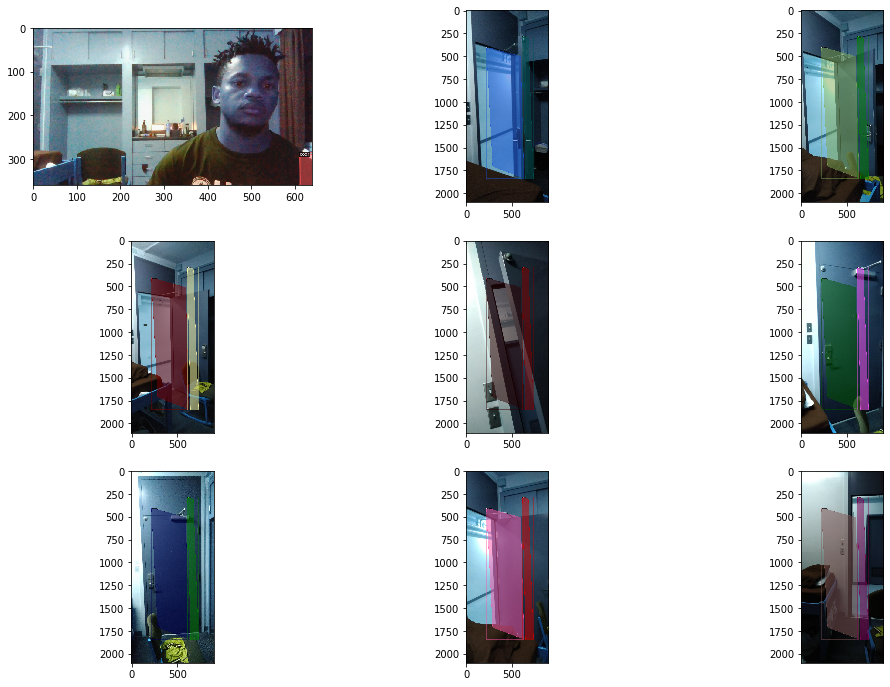

In [11]:
fish_metadata = MetadataCatalog.get("doornet_train")
dataset_dicts = create_dataset(data["train"])

plt.figure()

r = c = 3
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0
for d in random.sample(dataset_dicts,r*c):
    if i == r:
        i = 0
        j+=1
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata = fish_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axarr[i][j].imshow(Image.fromarray(vis.get_image()[:,:,::-1]))
    i+=1
    
plt.show()

-----

## Train

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("doornet_train",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/15 22:00:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (3, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (3,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (8,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (2,) in the model! Skipped.


[06/15 22:00:13 d2.engine.train_loop]: Starting training from iteration 0
[06/15 22:00:20 d2.utils.events]:  eta: 0:50:59  iter: 19  total_loss: 3.010  loss_cls: 1.109  loss_box_reg: 0.206  loss_mask: 0.689  loss_rpn_cls: 0.579  loss_rpn_loc: 0.419  time: 0.3295  data_time: 0.1381  lr: 0.000005  max_mem: 2708M
[06/15 22:00:27 d2.utils.events]:  eta: 0:51:29  iter: 39  total_loss: 2.778  loss_cls: 0.953  loss_box_reg: 0.217  loss_mask: 0.684  loss_rpn_cls: 0.477  loss_rpn_loc: 0.423  time: 0.3367  data_time: 0.1023  lr: 0.000010  max_mem: 2708M
[06/15 22:00:34 d2.utils.events]:  eta: 0:51:02  iter: 59  total_loss: 2.165  loss_cls: 0.745  loss_box_reg: 0.201  loss_mask: 0.679  loss_rpn_cls: 0.213  loss_rpn_loc: 0.391  time: 0.3276  data_time: 0.0502  lr: 0.000015  max_mem: 2849M
[06/15 22:00:41 d2.utils.events]:  eta: 0:50:17  iter: 79  total_loss: 1.897  loss_cls: 0.552  loss_box_reg: 0.266  loss_mask: 0.678  loss_rpn_cls: 0.105  loss_rpn_loc: 0.296  time: 0.3331  data_time: 0.1079  lr:

### Tensorboard

In [ ]:
%matplotlib inline 
%reload_ext tensorboard
%tensorboard --logdir output

## Inference 

<Figure size 432x288 with 0 Axes>

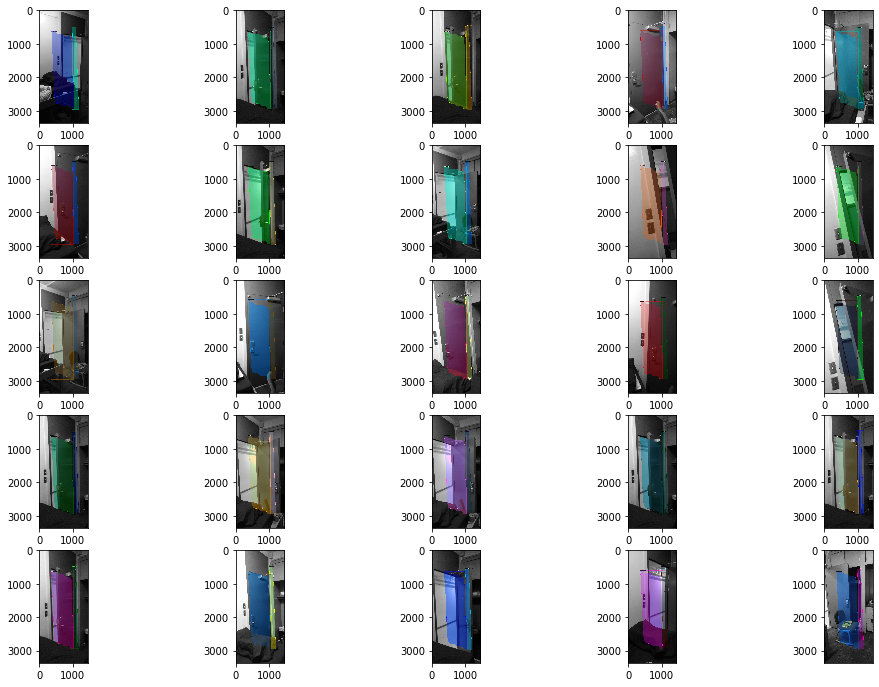

In [22]:
from detectron2.utils.visualizer import ColorMode

# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("doornet_val", )
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

plt.figure()

r = 5
c = 5
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0

dataset_dicts = create_dataset(data["val"])
for d in random.sample(dataset_dicts, r*c):
    if i == r:
        i = 0
        j+=1
        
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axarr[i][j].imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
    i+=1
plt.show()

----
### Evaluation on the validation set

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator  =  COCOEvaluator("doornet_val", cfg, False, output_dir="./output/")
val_loader =  build_detection_test_loader(cfg, "doornet_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/15 23:29:24 d2.data.common]: Serializing 43 elements to byte tensors and concatenating them all ...
[06/15 23:29:24 d2.data.common]: Serialized dataset takes 0.03 MiB
[06/15 23:29:24 d2.evaluation.evaluator]: Start inference on 43 images
[06/15 23:29:28 d2.evaluation.evaluator]: Inference done 11/43. 0.0940 s / img. ETA=0:00:06
[06/15 23:29:33 d2.evaluation.evaluator]: Inference done 34/43. 0.0945 s / img. ETA=0:00:01
[06/15 23:29:34 d2.evaluation.evaluator]: Total inference time: 0:00:07.157184 (0.188347 s / img per device, on 1 devices)
[06/15 23:29:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.085799 s / img per device, on 1 devices)
[06/15 23:29:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/15 23:29:34 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/15 23:29:34 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating i

OrderedDict([('bbox',
              {'AP': 99.30409391841582,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 99.30409391841582,
               'AP-door': 98.60818783683163,
               'AP-opening': 100.0}),
             ('segm',
              {'AP': 99.77895463965002,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': nan,
               'APm': nan,
               'APl': 99.77895463965002,
               'AP-door': 99.55790927930003,
               'AP-opening': 100.0})])

In [21]:
!pip install opencv-python
import cv2

def show_webcam(mirror=False):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        cv2.imshow('My Room', img)
        if cv2.waitKey(10) & 0xff == ord('q'): 
            break  # esc to quit
        print("CAMERA CLOSED")
    cv2.destroyAllWindows()


print("PRESS ESC TO QUIT")
show_webcam(mirror=True)

PRESS ESC TO QUIT


error: OpenCV(4.2.0) /io/opencv/modules/highgui/src/window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'
